# Objective of this tutorial
Get Data - Our data set will consist of an Excel file containing customer counts per date. We will learn how to read in the excel file for processing.
Prepare Data - The data is an irregular time series having duplicate dates. We will be challenged in compressing the data and coming up with next years forecasted customer count.
Analyze Data - We use graphs to visualize trends and spot outliers. Some built in computational tools will be used to calculate next years forecasted customer count.
Present Data - The results will be plotted.

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np
import sys
import matplotlib

%matplotlib inline

Create our own test data set

In [4]:
# set seed
np.seed(111)

# Function to generate test data
def CreateDataSet(Number=1):
    
    Output = []
    
    for i in range(Number):
        
        # Create a weekly (mondays) date range
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        # Create random data
        data = np.randint(low=25,high=1000,size=len(rng))
        
        # Status pool
        status = [1,2,3]
        
        # Make a random list of statuses
        random_status = [status[np.randint(low=0,high=len(status))] for i in range(len(rng))]
        
        # State pool
        states = ['GA','FL','fl','NY','NJ','TX']
        
        # Make a random list of states 
        random_states = [states[np.randint(low=0,high=len(states))] for i in range(len(rng))]
    
        Output.extend(zip(random_states, random_status, data, rng))
        
    return Output

Use the above function to generate out test data

In [7]:
dataSet = CreateDataSet(4)
df = pd.DataFrame(data=dataSet, columns = ['State', 'Status', 'CustomerCount', 'StatusDate'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   State          836 non-null    object        
 1   Status         836 non-null    int64         
 2   CustomerCount  836 non-null    int32         
 3   StatusDate     836 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(1), object(1)
memory usage: 23.0+ KB


In [8]:
df.head()

,State,Status,CustomerCount,StatusDate
0,FL,2,506,2009-01-05
1,TX,2,979,2009-01-12
2,GA,2,118,2009-01-19
3,fl,1,302,2009-01-26
4,FL,1,257,2009-02-02


In [11]:
# Save results to excel
df.to_excel('../../data/Lesson3.xlsx', index=False)
print('Done')

Done


Grab the data from Excel

In [12]:
# Loaction of the file
Location = r'../../data/Lesson3.xlsx'
# Parse a specific sheet
df = pd.read_excel(Location, 0, index_col='StatusDate')
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [13]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name='StatusDate', length=836, freq=None)

In [14]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,FL,2,506
2009-01-12,TX,2,979
2009-01-19,GA,2,118
2009-01-26,fl,1,302
2009-02-02,FL,1,257


# Prepare Data
This section attempts to clean up the data for analysis.
<ol>
    <li>Make sure the state column is all in upper case</li>
    <li>Only select records where the account status is equal to "1"</li>
    <li>Merge (NJ and NY) to NY in the state column</li>
    <li>Remove any outliers (any odd results in the data set)</li>
</ol>

Take a quick look on how some of the state values are upper case and some are lower case

In [15]:
df['State'].unique()

array(['FL', 'TX', 'GA', 'fl', 'NY', 'NJ'], dtype=object)

To convert all the State values to upper case we will use the upper() function and the dataframe's apply attribute. The lambda function simply will apply the upper function to each value in the State column.

In [16]:
# Clean State Column, Convert to upper Case
df['State'] = df.State.apply(lambda x: x.upper())
df['State'].unique()

array(['FL', 'TX', 'GA', 'NY', 'NJ'], dtype=object)

In [18]:
# Only grab where status == 1
mask = df['Status'] == 1
df = df[mask]
df

,State,Status,CustomerCount
StatusDate,,,
2009-01-26,FL,1,302
2009-02-02,FL,1,257
2009-03-23,FL,1,604
2009-04-13,NY,1,82
2009-04-20,GA,1,408
...,...,...,...
2012-10-22,NY,1,801
2012-10-29,NJ,1,390
2012-11-19,NY,1,541


To turn the NJ states to NY we simply...

[df.State == 'NJ'] - Find all records in the State column where they are equal to NJ.
df.State[df.State == 'NJ'] = 'NY' - For all records in the State column where they are equal to NJ, replace them with NY.

In [19]:
# Convert NJ to NY
mask = df.State == 'NJ'
df['State'][mask] = 'NY'
df

,State,Status,CustomerCount
StatusDate,,,
2009-01-26,FL,1,302
2009-02-02,FL,1,257
2009-03-23,FL,1,604
2009-04-13,NY,1,82
2009-04-20,GA,1,408
...,...,...,...
2012-10-22,NY,1,801
2012-10-29,NY,1,390
2012-11-19,NY,1,541


We see that we have a much cleaner data set to work with


In [20]:
df['State'].unique()

array(['FL', 'NY', 'GA', 'TX'], dtype=object)

At this point we may want to graph the data to check for any outliers or inconsistencies in the data. We will be using the plot() attribute of the dataframe.

As you can see from the graph below it is not very conclusive and is probably a sign that we need to perform some more data preparation.

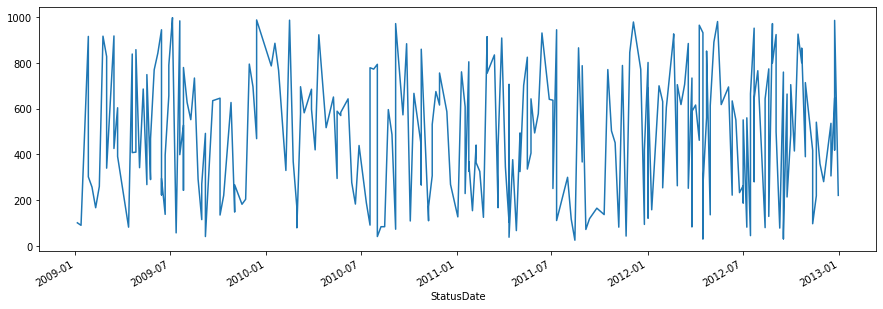

In [22]:
df['CustomerCount'].plot(figsize=(15,5));

If we take a look at the data, we begin to realize that there are multiple values for the same State, StatusDate, and Status combination. It is possible that this means the data you are working with is dirty/bad/inaccurate, but we will assume otherwise. We can assume this data set is a subset of a bigger data set and if we simply add the values in the CustomerCount column per State, StatusDate, and Status we will get the Total Customer Count per day.

In [23]:
sortdf = df[df['State'] == 'NY'].sort_index(axis=0)
sortdf.head(10)

,State,Status,CustomerCount
StatusDate,,,
2009-01-12,NY,1,90
2009-02-09,NY,1,167
2009-04-13,NY,1,82
2009-04-27,NY,1,858
2009-05-04,NY,1,342
2009-05-11,NY,1,686
2009-05-18,NY,1,268
2009-05-25,NY,1,290
2009-06-01,NY,1,770


Our task is now to create a new dataframe that compresses the data so we have daily customer counts per State and StatusDate. We can ignore the Status column since all the values in this column are of value 1. To accomplish this we will use the dataframe's functions groupby and sum().

Note that we had to use reset_index . If we did not, we would not have been able to group by both the State and the StatusDate since the groupby function expects only columns as inputs. The reset_index function will bring the index StatusDate back to a column in the dataframe.

In [26]:
# Group by State and StatusDate
Daily = df.reset_index().groupby(['State', 'StatusDate']).sum()
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-26       2           1218
      2009-02-02       1            257
      2009-02-16       1            260
      2009-02-23       1            917
      2009-03-02       1            340

In [28]:
# What is the index of the data frame
Daily.index

MultiIndex([('FL', '2009-01-26'),
            ('FL', '2009-02-02'),
            ('FL', '2009-02-16'),
            ('FL', '2009-02-23'),
            ('FL', '2009-03-02'),
            ('FL', '2009-03-16'),
            ('FL', '2009-03-23'),
            ('FL', '2009-04-20'),
            ('FL', '2009-04-27'),
            ('FL', '2009-05-18'),
            ...
            ('TX', '2012-04-30'),
            ('TX', '2012-07-02'),
            ('TX', '2012-07-09'),
            ('TX', '2012-07-16'),
            ('TX', '2012-08-20'),
            ('TX', '2012-09-17'),
            ('TX', '2012-09-24'),
            ('TX', '2012-10-22'),
            ('TX', '2012-10-29'),
            ('TX', '2012-12-24')],
           names=['State', 'StatusDate'], length=244)

In [29]:
Daily.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 244 entries, ('FL', Timestamp('2009-01-26 00:00:00')) to ('TX', Timestamp('2012-12-24 00:00:00'))
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Status         244 non-null    int64
 1   CustomerCount  244 non-null    int64
dtypes: int64(2)
memory usage: 6.0+ KB


In [30]:
# Select the State Index
Daily.index.levels[0]

Index(['FL', 'GA', 'NY', 'TX'], dtype='object', name='State')

In [31]:
# Select the StatusDate index
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-26', '2009-02-02',
               '2009-02-09', '2009-02-16', '2009-02-23', '2009-03-02',
               '2009-03-16', '2009-03-23',
               ...
               '2012-10-15', '2012-10-22', '2012-10-29', '2012-11-12',
               '2012-11-19', '2012-11-26', '2012-12-03', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name='StatusDate', length=174, freq=None)

Lets now plot the data per State.

As you can see by breaking the graph up by the State column we have a much clearer picture on how the data looks like. Can you spot any outliers?

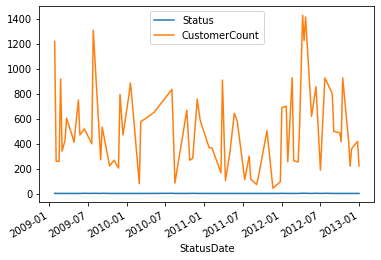

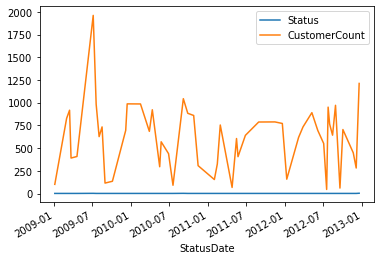

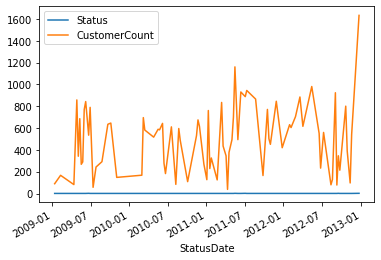

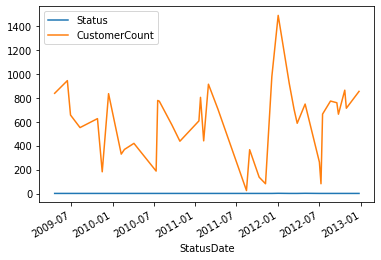

In [32]:
Daily.loc['FL'].plot()
Daily.loc['GA'].plot()
Daily.loc['NY'].plot()
Daily.loc['TX'].plot();

We can also just plot the data on a specific date, like 2012. We can now clearly see that the data for these states is all over the place. since the data consist of weekly customer counts, the variability of the data seems suspect. For this tutorial we will assume bad data and proceed.

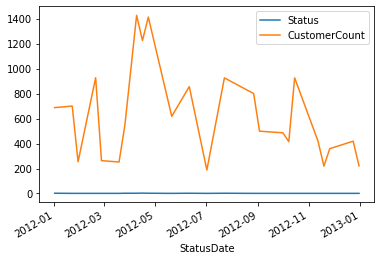

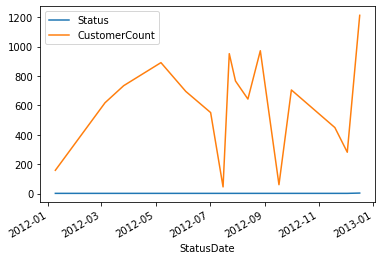

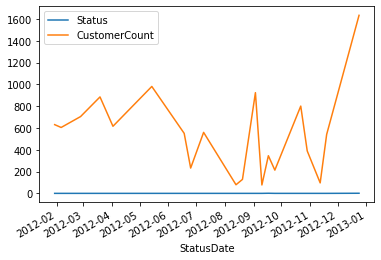

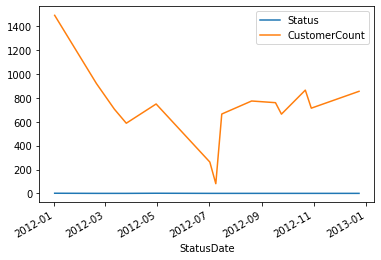

In [33]:
Daily.loc['FL']['2012':].plot()
Daily.loc['GA']['2012':].plot()
Daily.loc['NY']['2012':].plot()
Daily.loc['TX']['2012':].plot();

We will assume that per month the customer count should remain relatively steady. Any data outside a specific range in that month will be removed from the data set. The final result should have smooth graphs with no spikes.

StateYearMonth - Here we group by State, Year of StatusDate, and Month of StatusDate.
<p>Daily['Outlier'] - A boolean (True or False) value letting us know if the value in the CustomerCount column is ouside the acceptable range.</p>
<p>We will be using the attribute transform instead of apply. The reason is that transform will keep the shape(# of rows and columns) of the dataframe the same and apply will not. By looking at the previous graphs, we can realize they are not resembling a gaussian distribution, this means we cannot use summary statistics like the mean and stDev. We use percentiles instead. Note that we run the risk of eliminating good data</p>

In [45]:
# Calculate Outliers
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0), Daily.index.get_level_values(1).year, Daily.index.get_level_values(1).month])
Daily['Lower'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.25) - (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Upper'] = StateYearMonth['CustomerCount'].transform( lambda x: x.quantile(q=.75) + (1.5*x.quantile(q=.75)-x.quantile(q=.25)) )
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper']) 

# Remove Outliers
Daily = Daily[Daily['Outlier'] == False]

<p>The dataframe named Daily will hold customer counts that have been aggregated per day. The original data (df) has multiple records per day. We are left with a data set that is indexed by both the state and the StatusDate. The Outlier column should be equal to False signifying that the record is not an outlier.</p>

In [46]:
Daily.head()

Status  CustomerCount   Lower    Upper  Outlier
State StatusDate                                                 
FL    2009-01-26       2           1218  609.00  1827.00    False
      2009-02-02       1            257 -365.75  1212.75    False
      2009-02-16       1            260 -365.75  1212.75    False
      2009-02-23       1            917 -365.75  1212.75    False
      2009-03-02       1            340   -6.50   904.50    False

In [47]:
Daily.index

MultiIndex([('FL', '2009-01-26'),
            ('FL', '2009-02-02'),
            ('FL', '2009-02-16'),
            ('FL', '2009-02-23'),
            ('FL', '2009-03-02'),
            ('FL', '2009-03-16'),
            ('FL', '2009-03-23'),
            ('FL', '2009-04-20'),
            ('FL', '2009-04-27'),
            ('FL', '2009-05-18'),
            ...
            ('TX', '2012-04-30'),
            ('TX', '2012-07-02'),
            ('TX', '2012-07-09'),
            ('TX', '2012-07-16'),
            ('TX', '2012-08-20'),
            ('TX', '2012-09-17'),
            ('TX', '2012-09-24'),
            ('TX', '2012-10-22'),
            ('TX', '2012-10-29'),
            ('TX', '2012-12-24')],
           names=['State', 'StatusDate'], length=244)

<p>We create a separate dataframe named ALL which groups the Daily dataframe by StatusDate. We are essentially getting rid of the State column. The Max column represents the maximum customer count per month. The Max column is used to smooth out the graph.</p>

In [54]:
# Combine all markets
# Get the mx customer count by Date
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())
ALL.columns = ['CustomerCount'] # rename column

# Group by Year and Month
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# What is the max customer count per Year and Month
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()


,CustomerCount,Max
StatusDate,,
2009-01-05,101,1218
2009-01-12,90,1218
2009-01-26,1218,1218
2009-02-02,257,917
2009-02-09,167,917


As you can see from the ALL dataframe above, in the month of January 2009, the maximum customer count was 901. If we had used apply, we would have got a dataframe with (Year and Month) as the index and just the Max column with the value of 901.

<p>There is also an interest to gauge if the current customer counts were reaching certain goals the company had established. The task here is to visually show if the current customer counts are meeting the goals listed below. We will call the goals <strong>BHAG </strong>(Big Hairy Annual Goal).</p>
<ul>
    <li>12/31/2011 - 1,000 customers</li>
    <li>12/31/2012 - 2,000 customers</li>
    <li>12/31/2013 - 3,000 customers</li>
</ul>
<p>We will be using the date_range function to create our dates.</p>
<p>Definition: date_range(start=None, end=None, periods=None, freq='D', tz=None, normalize=False, name=None, closed=None)</p>
<p>Docstring: Return a fixed frequency datetime index, with day (calendar) as the default frequency</p>
    
<p>By choosing the frequency to be A or annual we will be able to get the three target dates from above.</p>
    

In [57]:
# Create the BHAG dataframe
data = [1000, 2000, 3000]
idx = pd.date_range(start='12/31/2011', end='12/31/2013', freq='A')
BHAG = pd.DataFrame(data, index=idx, columns=['BHAG'])
BHAG


,BHAG
2011-12-31,1000
2012-12-31,2000
2013-12-31,3000


<p>Combining dataframes as we have learned in previous lesson is made simple using the concat function. Remember when we choose axis = 0 we are appending row wise.</p>

In [60]:
# Combine the BHAG and the ALL data set
combined = pd.concat([ALL, BHAG], axis=0)
combined = combined.sort_index(axis=0)
combined

,CustomerCount,Max,BHAG
2009-01-05,101.0,1218.0,NaN
2009-01-12,90.0,1218.0,NaN
2009-01-26,1218.0,1218.0,NaN
2009-02-02,257.0,917.0,NaN
2009-02-09,167.0,917.0,NaN
...,...,...,...
2012-12-17,1213.0,2907.0,NaN
2012-12-24,2907.0,2907.0,NaN
2012-12-31,221.0,2907.0,NaN
2012-12-31,NaN,NaN,2000.0


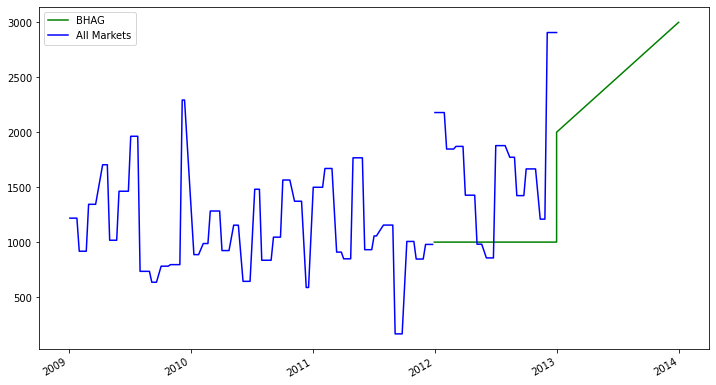

In [65]:
fig, axes = plt.subplots(figsize=(12, 7))
combined['BHAG'].fillna(method='pad').plot(color='green', label='BHAG');
combined['Max'].plot(color='blue', label='All Markets');
plt.legend(loc='best');

<p>There was also a need to forecast next year's customer count and we can do this in a couple of simple steps. We will first group the combined dataframe by Year and place the maximum customer count for that year. This will give us one row per Year.</p>

In [67]:
# Group by Year and then get the max value per year
Year = combined.groupby(lambda x: x.year).max()
Year

,CustomerCount,Max,BHAG
2009,2293.0,2293.0,NaN
2010,1565.0,1565.0,NaN
2011,1767.0,1767.0,1000.0
2012,2907.0,2907.0,2000.0
2013,NaN,NaN,3000.0


In [68]:
# Add a column representing the percent change per year
Year['YR_PCT_Change'] = Year['Max'].pct_change(periods=1)
Year

,CustomerCount,Max,BHAG,YR_PCT_Change
2009,2293.0,2293.0,NaN,NaN
2010,1565.0,1565.0,NaN,-0.317488
2011,1767.0,1767.0,1000.0,0.129073
2012,2907.0,2907.0,2000.0,0.645161
2013,NaN,NaN,3000.0,0.000000


<p>To get next year's end customer count we will assume our current growth rate remains constant. We then will increase this years customer count by that amount and that will be our forecast for next year.</p>

In [71]:
(1 + Year.loc[2012,'YR_PCT_Change']) * Year.loc[2012,'Max']

4782.483870967742

Present Data
Create individual Graphs per State

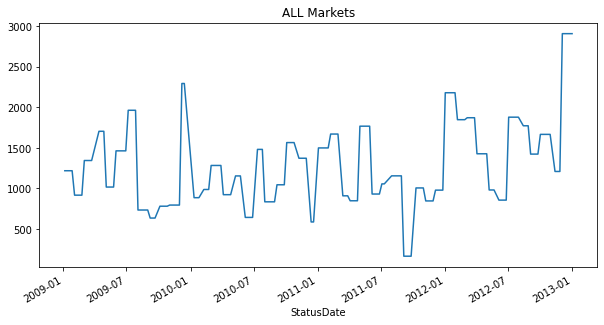

In [72]:
# First Graph
ALL['Max'].plot(figsize=(10, 5));
plt.title('ALL Markets');

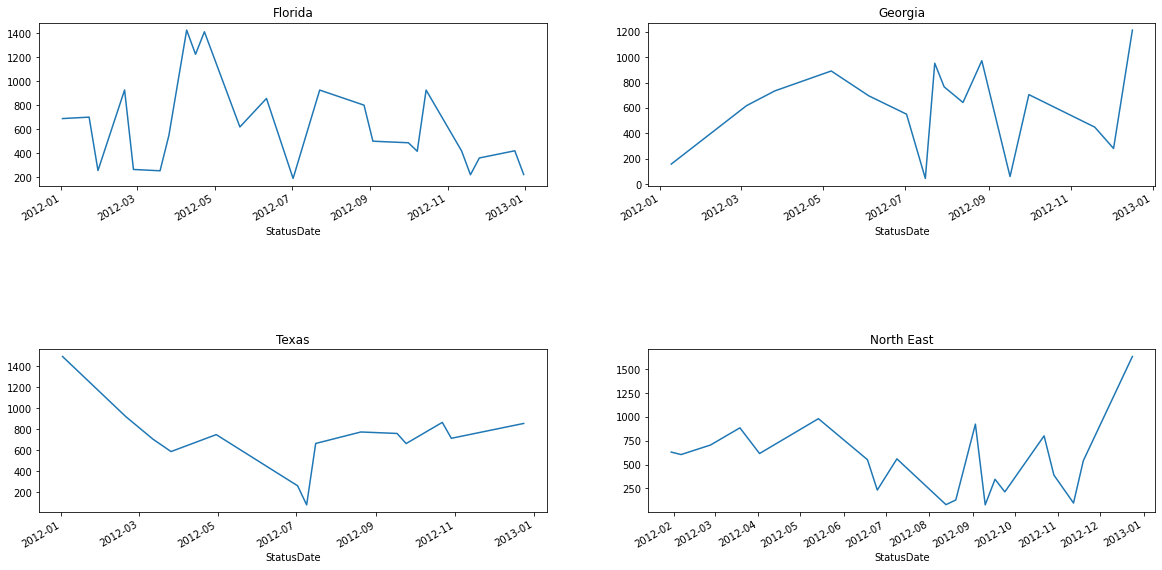

In [76]:
# Last four Graphs
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
fig.subplots_adjust(hspace=1.0) ## Create space between plots
Daily.loc['FL']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,0])
Daily.loc['GA']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[0,1]) 
Daily.loc['TX']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,0]) 
Daily.loc['NY']['CustomerCount']['2012':].fillna(method='pad').plot(ax=axes[1,1]) 

# Add titles
axes[0,0].set_title('Florida')
axes[0,1].set_title('Georgia')
axes[1,0].set_title('Texas')
axes[1,1].set_title('North East');